In [1]:
import salobj
import SALPY_calibrationElectrometer as cEl
import SALPY_atMonochromator as atM
import SALPY_sedSpectrometer as sedS
import nest_asyncio
nest_asyncio.apply()
import asyncio
import time
import os
import posixpath
import aiohttp # $ pip install aiohttp
from contextlib import closing
from astropy.io import fits
from matplotlib import pyplot as py

try:
    from urlparse import urlsplit
    from urllib import unquote
except ImportError: # Python 3
    from urllib.parse import urlsplit, unquote
    
%matplotlib inline

/home/saluser/lsst_repos/salobj/python/salobj/test_utils.py:37: UserWarning: Could not import SALPY_Test; TestComponent will not work
  warnings.warn("Could not import SALPY_Test; TestComponent will not work")


In [2]:
import asyncio

In [3]:
loop = asyncio.get_event_loop()

In [1]:
import salobj
import SALPY_MTMount 
import asyncio

loop = asyncio.get_event_loop()

remote = salobj.Remote(SALPY_MTMount)

moveto_topic = remote.cmd_moveToTarget.DataType()
moveto_topic.az_angle = 45.
moveto_topic.el_angle = 60.
moveto_topic.cablewrap_orientation = "CW"  # Need to check cable wrap orientation probably

moveto_task = loop.run_until_complete(remote.cmd_moveToTarget.start(moveto_topic, timeout=60.)) # adding a timeout of 60s

print(moveto_task.ack) # now you can check the ack response

ModuleNotFoundError: No module named 'salobj'

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO,
                format='[%(asctime)s] [%(name)-12s:%(lineno)-4d] [%(levelname)-8s]: %(message)s',
                datefmt='%m-%d %H:%M:%S')

In [3]:
def url2filename(url):
    """Return basename corresponding to url.
    >>> print(url2filename('http://example.com/path/to/file%C3%80?opt=1'))
    fileÀ
    >>> print(url2filename('http://example.com/slash%2fname')) # '/' in name
    Traceback (most recent call last):
    ...
    ValueError
    """
    urlpath = urlsplit(url).path
    basename = posixpath.basename(unquote(urlpath))
    if (os.path.basename(basename) != basename or
        unquote(posixpath.basename(urlpath)) != basename):
        raise ValueError  # reject '%2f' or 'dir%5Cbasename.ext' on Windows
    return basename

@asyncio.coroutine
def wget(url, chunk_size=1<<15):
    filename = url2filename(url)
    logging.info('downloading %s', filename)
    with closing(aiohttp.ClientSession()) as session:
        response = yield from session.get(url)
        with closing(response), open(filename, 'wb') as file:
            while True: # save file
                chunk = yield from response.content.read(chunk_size)
                if not chunk:
                    break
                file.write(chunk)
        logging.info('done %s', filename)
    return filename

In [4]:
class WavelengthCalibrationSequence:
    def __init__(self):
        self.sedSpectrometer = salobj.Remote(sedS, f"sedSpectrometer")
        self.calibrationElectrometer = salobj.Remote(cEl, f"calibrationElectrometer:1")
        # atMonochromator = salobj.Remote(atM, f"atMonochromator")
        
        self.spectrometer_files = []
        self.electrometer_files = []
        
    async def startUp(self):
        start_topic_sed = self.sedSpectrometer.cmd_start.DataType()
        start_topic_sed.settingsToApply = 'Default'

        start_topic_cel = self.calibrationElectrometer.cmd_start.DataType()
        start_topic_cel.settingsToApply = 'Default'

        task_start_sed = self.sedSpectrometer.cmd_start.start(start_topic_sed)
        task_start_cel = self.calibrationElectrometer.cmd_start.start(start_topic_cel)
        
        group1 = await asyncio.gather(task_start_cel, task_start_cel)
        
        for task in group1:
            print(task.ack)

#         print(task_start_sed)
#         print(task_start_cel)
        
        # TODO: Make sure the state is right
        
        task_enable_sed = self.sedSpectrometer.cmd_enable.start(self.sedSpectrometer.cmd_enable.DataType())
        task_enable_cel = self.calibrationElectrometer.cmd_enable.start(self.calibrationElectrometer.cmd_enable.DataType())

        group2 = await asyncio.gather(task_enable_cel, task_enable_sed)
        for task in group2:
            detailed_state = await seq.calibrationElectrometer.evt_detailedState
        
#         print(task_enable_sed)
#         print(task_enable_cel)
        
        # TODO: Make sure the state is right

    async def takeSequence(self, expt_time = 10.):

        ecapture_topic = self.calibrationElectrometer.cmd_startScanDt.DataType()
        ecapture_topic.time = expt_time+2

        capture_topic = self.sedSpectrometer.cmd_captureSpectImage.DataType()
        capture_topic.imageType = 'test'
        capture_topic.integrationTime = expt_time
        capture_topic.lamp = 'lamp'

        async def start_after():
            detailed_state = await self.calibrationElectrometer.evt_detailedState.next(flush=True)
            logging.info('Received {} from electrometer...'
                  ' wait 1sec for acquisition to stabilize...'.format(
                detailed_state.detailedState))
            await asyncio.sleep(1.)
            logging.info('Start aquisition of spectra...')
            return await self.sedSpectrometer.cmd_captureSpectImage.start(capture_topic)
        task1_capture = self.calibrationElectrometer.cmd_startScanDt.start(ecapture_topic)
        task2_capture = start_after()
        lfo1 = self.calibrationElectrometer.evt_largeFileObjectAvailable.next(flush=True, 
                                                                    timeout=expt_time*2)
        lfo2 = self.sedSpectrometer.evt_largeFileObjectAvailable.next(flush=True, 
                                                                    timeout=expt_time*2)

        
        print('Starting acquisition and waiting for data...')
        
        group1 = await asyncio.gather(task1_capture, task2_capture, lfo1, lfo2)
        
        print(group1[0].ack)
        print(group1[1].ack)        
        print(group1[2].url)
        print(group1[3].url)
        
        self.spectrometer_files.append(group1[2].url)
        self.electrometer_files.append(group1[3].url)

        wget_electrometer = wget(group1[2].url)
        wget_spectrometer = wget(group1[3].url)
        
        group2 = await asyncio.gather(wget_electrometer,
                                      wget_spectrometer)
        
#         lfo = sedSpectrometer.evt_largeFileObjectAvailable.next(flush=True, timeout=5)
#         print(lfo)

In [5]:
seq = WavelengthCalibrationSequence()

In [6]:
loop = asyncio.get_event_loop()

In [ ]:
loop.run_until_complete(wget("http://140.252.32.244:8000/testlamp1538599032.140548.fits"))

In [7]:
print('Start')
loop.run_until_complete(seq.takeSequence())
print('Done')

[10-03 17:39:17] [root        :56  ] [INFO    ]: Received 10 from electrometer... wait 1sec for acquisition to stabilize...


Start
Starting acquisition and waiting for data...


[10-03 17:39:18] [root        :58  ] [INFO    ]: Start aquisition of spectra...
[10-03 17:39:34] [root        :20  ] [INFO    ]: downloading _1538602774.16683793.fits
[10-03 17:39:34] [root        :20  ] [INFO    ]: downloading testlamp1538602758.955070.fits
[10-03 17:39:34] [root        :29  ] [INFO    ]: done _1538602774.16683793.fits
/home/saluser/stack/python/miniconda3-4.3.21/lib/python3.6/contextlib.py:185: RuntimeWarning: coroutine 'ClientSession.close' was never awaited
  self.thing.close()
[10-03 17:39:34] [asyncio     :1260] [ERROR   ]: Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f86501e8390>
[10-03 17:39:34] [root        :29  ] [INFO    ]: done testlamp1538602758.955070.fits
[10-03 17:39:34] [asyncio     :1260] [ERROR   ]: Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f86501e89e8>


303
303
http://140.252.33.129:8000/_1538602774.16683793.fits
http://140.252.32.244:8000/testlamp1538602758.955070.fits
Done


In [8]:
elect_file = url2filename(seq.electrometer_files[0])
spect_file = url2filename(seq.spectrometer_files[0])
print(elect_file, spect_file)

testlamp1538602758.955070.fits _1538602774.16683793.fits


In [9]:
elect_data = fits.getdata(elect_file).T
spect_data = fits.getdata(spect_file).T

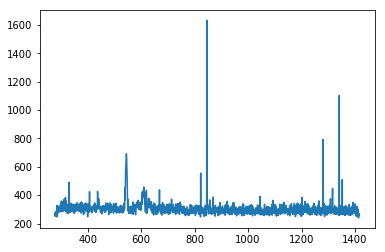

In [10]:
py.plot(elect_data[0],elect_data[1])

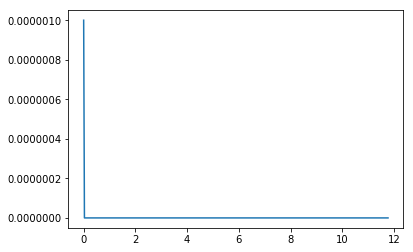

In [11]:
py.plot(spect_data[0],spect_data[1])

In [ ]:
print('Start')
task = await seq.startUp()
print('Done')

In [ ]:
print('Start')
task = await seq.takeSequence()
print('Done')

In [ ]:
print('Start')
task = asyncio.ensure_future(seq.takeSequence())
print('Done')

In [ ]:
foo = seq.calibrationElectrometer.evt_detailedState

In [ ]:
foo.

In [ ]:
lfo = await seq.sedSpectrometer.evt_detailedState.next(flush=True)
print(lfo.detailedState)
lfo = await seq.sedSpectrometer.evt_detailedState.next(flush=True)
print(lfo.detailedState)

In [ ]:
lfo = await seq.calibrationElectrometer.evt_detailedState.next(flush=True)
print(lfo.detailedState)
lfo = await seq.calibrationElectrometer.evt_detailedState.next(flush=True)
print(lfo.detailedState)

In [ ]:
enable_topic = sedSpectrometer.cmd_enable.DataType()
task_enable = asyncio.ensure_future(sedSpectrometer.cmd_enable.start(enable_topic))
loop.run_until_complete(task_enable)
print(task_enable.result().ack)

In [ ]:
expt_time = 10.

ecapture_topic = calibrationElectrometer.cmd_startScanDt.DataType()
ecapture_topic.time = expt_time+2

capture_topic = sedSpectrometer.cmd_captureSpectImage.DataType()
capture_topic.imageType = 'test'
capture_topic.integrationTime = 10.
capture_topic.lamp = 'lamp'

task1_capture = asyncio.ensure_future(calibrationElectrometer.cmd_startScanDt.start(ecapture_topic))
task2_capture = asyncio.ensure_future(sedSpectrometer.cmd_captureSpectImage.start(capture_topic))
print('here')

loop.run_until_complete(asyncio.wait([task1_capture, task2_capture]))

print(task1_capture.result().ack)
print(task2_capture.result().ack)

lfo = sedSpectrometer.evt_largeFileObjectAvailable.next(flush=True, timeout=5)
print(lfo)

In [ ]:
task.

In [ ]:
sedSpectrometer.cmd_disable.start(sedSpectrometer.cmd_disable.DataType())

In [ ]:
state1 = sedSpectrometer.evt_summaryState.get()
print(state1.summaryState)

In [ ]:
enable = sedSpectrometer.cmd_enable.start(sedSpectrometer.cmd_enable.DataType())

In [ ]:
state2 = sedSpectrometer.evt_summaryState.get()
print(state2.summaryState)

In [ ]:
calibrationElectrometer.evt_heartbeat.next()

In [ ]:
captureSpect = sedSpectrometer.cmd_captureSpectImage.DataType()

In [ ]:
captureSpect.integrationTime = 10.
captureSpect.imageType='test'
captureSpect.lamp='lamp'

In [ ]:
captureSI = sedSpectrometer.cmd_captureSpectImage.start(captureSpect)

In [ ]:
def enable(future):
    print(future.result().ack)

In [ ]:
start_topic = sedSpectrometer.cmd_start.DataType()
start_topic.settingsToApply = 'Default'
task_start = asyncio.ensure_future(sedSpectrometer.cmd_start.start(start_topic))        
task_start.add_done_callback(enable)
print(task_start.result().ack)

In [ ]:
class Test:
    def __init__(self):
        self.sedSpectrometer = salobj.Remote(sedS, f"sedSpectrometer")
        
    def bring_up(self):
        cmd_data_start = sedSpectrometer.cmd_start.DataType()
        cmd_data_start.settingsToApply = 'Default'
        sedSpectrometer.cmd_start.start(start_topic))        
        asyncio.gather(task_start)
        print(task_start.result().ack)
    

In [ ]:
test = Test()

In [ ]:
test.bring_up()

In [ ]:
loop = asyncio.get_event_loop()

In [ ]:
asyncio.Task.all_tasks()

In [ ]:
loop